# Imports

In [1]:
!pip install timm

In [2]:
import pickle

import os
import numpy as np
import torch
import timm
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
import pandas as pd
from sklearn.model_selection import train_test_split
# from dataset import GlaucomaDataset
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Class

In [5]:

import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
import pandas as pd
import numpy as np
import cv2
from torchvision.transforms.functional import to_tensor


class GlaucomaDataset(Dataset):
    def __init__(self, root_dir, csv_file, image_dir='Images_Square', mask_dir='Masks_Square', split='train', output_size=(512,512), max_images=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.split = split
        self.output_size = output_size
        self.max_images = max_images
        self.labels_df = pd.read_csv(os.path.join(root_dir, csv_file))

        # Define transformations for images and masks
        self.image_transform = Compose([
            Resize(output_size),
            ToTensor(),
            # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = Compose([
            Resize(output_size),
            ToTensor()
        ])

        # Load image file names
        self.image_filenames = self.get_image_filenames(root_dir, image_dir, max_images)

        print(f'Successfully loaded {split} dataset with {len(self.image_filenames)} images.')

    def get_image_filenames(self, root_dir, image_dir, max_images):
        image_filenames = [f for f in os.listdir(os.path.join(root_dir, image_dir)) if not f.startswith('.')]
        return image_filenames[:max_images] if max_images is not None else image_filenames

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image using cv2
        img_name = os.path.join(self.root_dir, self.image_dir, self.image_filenames[idx])
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, self.output_size)  # Resize the image

        # Initialize an empty mask with the same spatial dimensions as the image
        mask = np.zeros((*self.output_size, 1), dtype=np.uint8)

        # Load mask if it exists
        mask_name = os.path.join(self.root_dir, self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))
        if os.path.exists(mask_name):
            mask_loaded = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            mask_loaded = cv2.resize(mask_loaded, self.output_size)  # Resize the mask
            mask = mask_loaded[:, :, None]  # Add channel dimension

        # Concatenate image and mask
        img_with_mask = np.concatenate([img, mask], axis=-1)

        # Pad with zeros if necessary to ensure the concatenated result has exactly 5 channels
        if img_with_mask.shape[-1] < 5:
            padding = 5 - img_with_mask.shape[-1]
            img_with_mask = np.pad(img_with_mask, ((0, 0), (0, 0), (0, padding)), 'constant')

        # Convert the combined image and mask to a tensor without normalization
        img_with_mask_tensor = ToTensor()(img_with_mask)

        # Ensure the tensor has 5 channels where the last two channels are the mask
        if img_with_mask_tensor.shape[0] < 5:
            padding = 5 - img_with_mask_tensor.shape[0]
            padding_tensor = torch.zeros((padding, *self.output_size), dtype=torch.float32)
            img_with_mask_tensor = torch.cat([img_with_mask_tensor, padding_tensor], dim=0)

        # Get label
        label = self.labels_df.loc[self.labels_df['imageID'] == self.image_filenames[idx], 'binaryLabels'].values[0]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_with_mask_tensor, label_tensor





# Loading Dataset

In [6]:
# !ls drive/MyDrive/G1020

In [7]:


# root_dir='../archive/G1020'
root_dir='drive/MyDrive/G1020'


batch_size=16

# Initialize the dataset
dataset = GlaucomaDataset(root_dir=root_dir, csv_file='G1020.csv',)

# Initialize the data loader
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Successfully loaded train dataset with 1020 images.


In [8]:
len(dataset)

1020

# Check if correct masks and labels are loaded

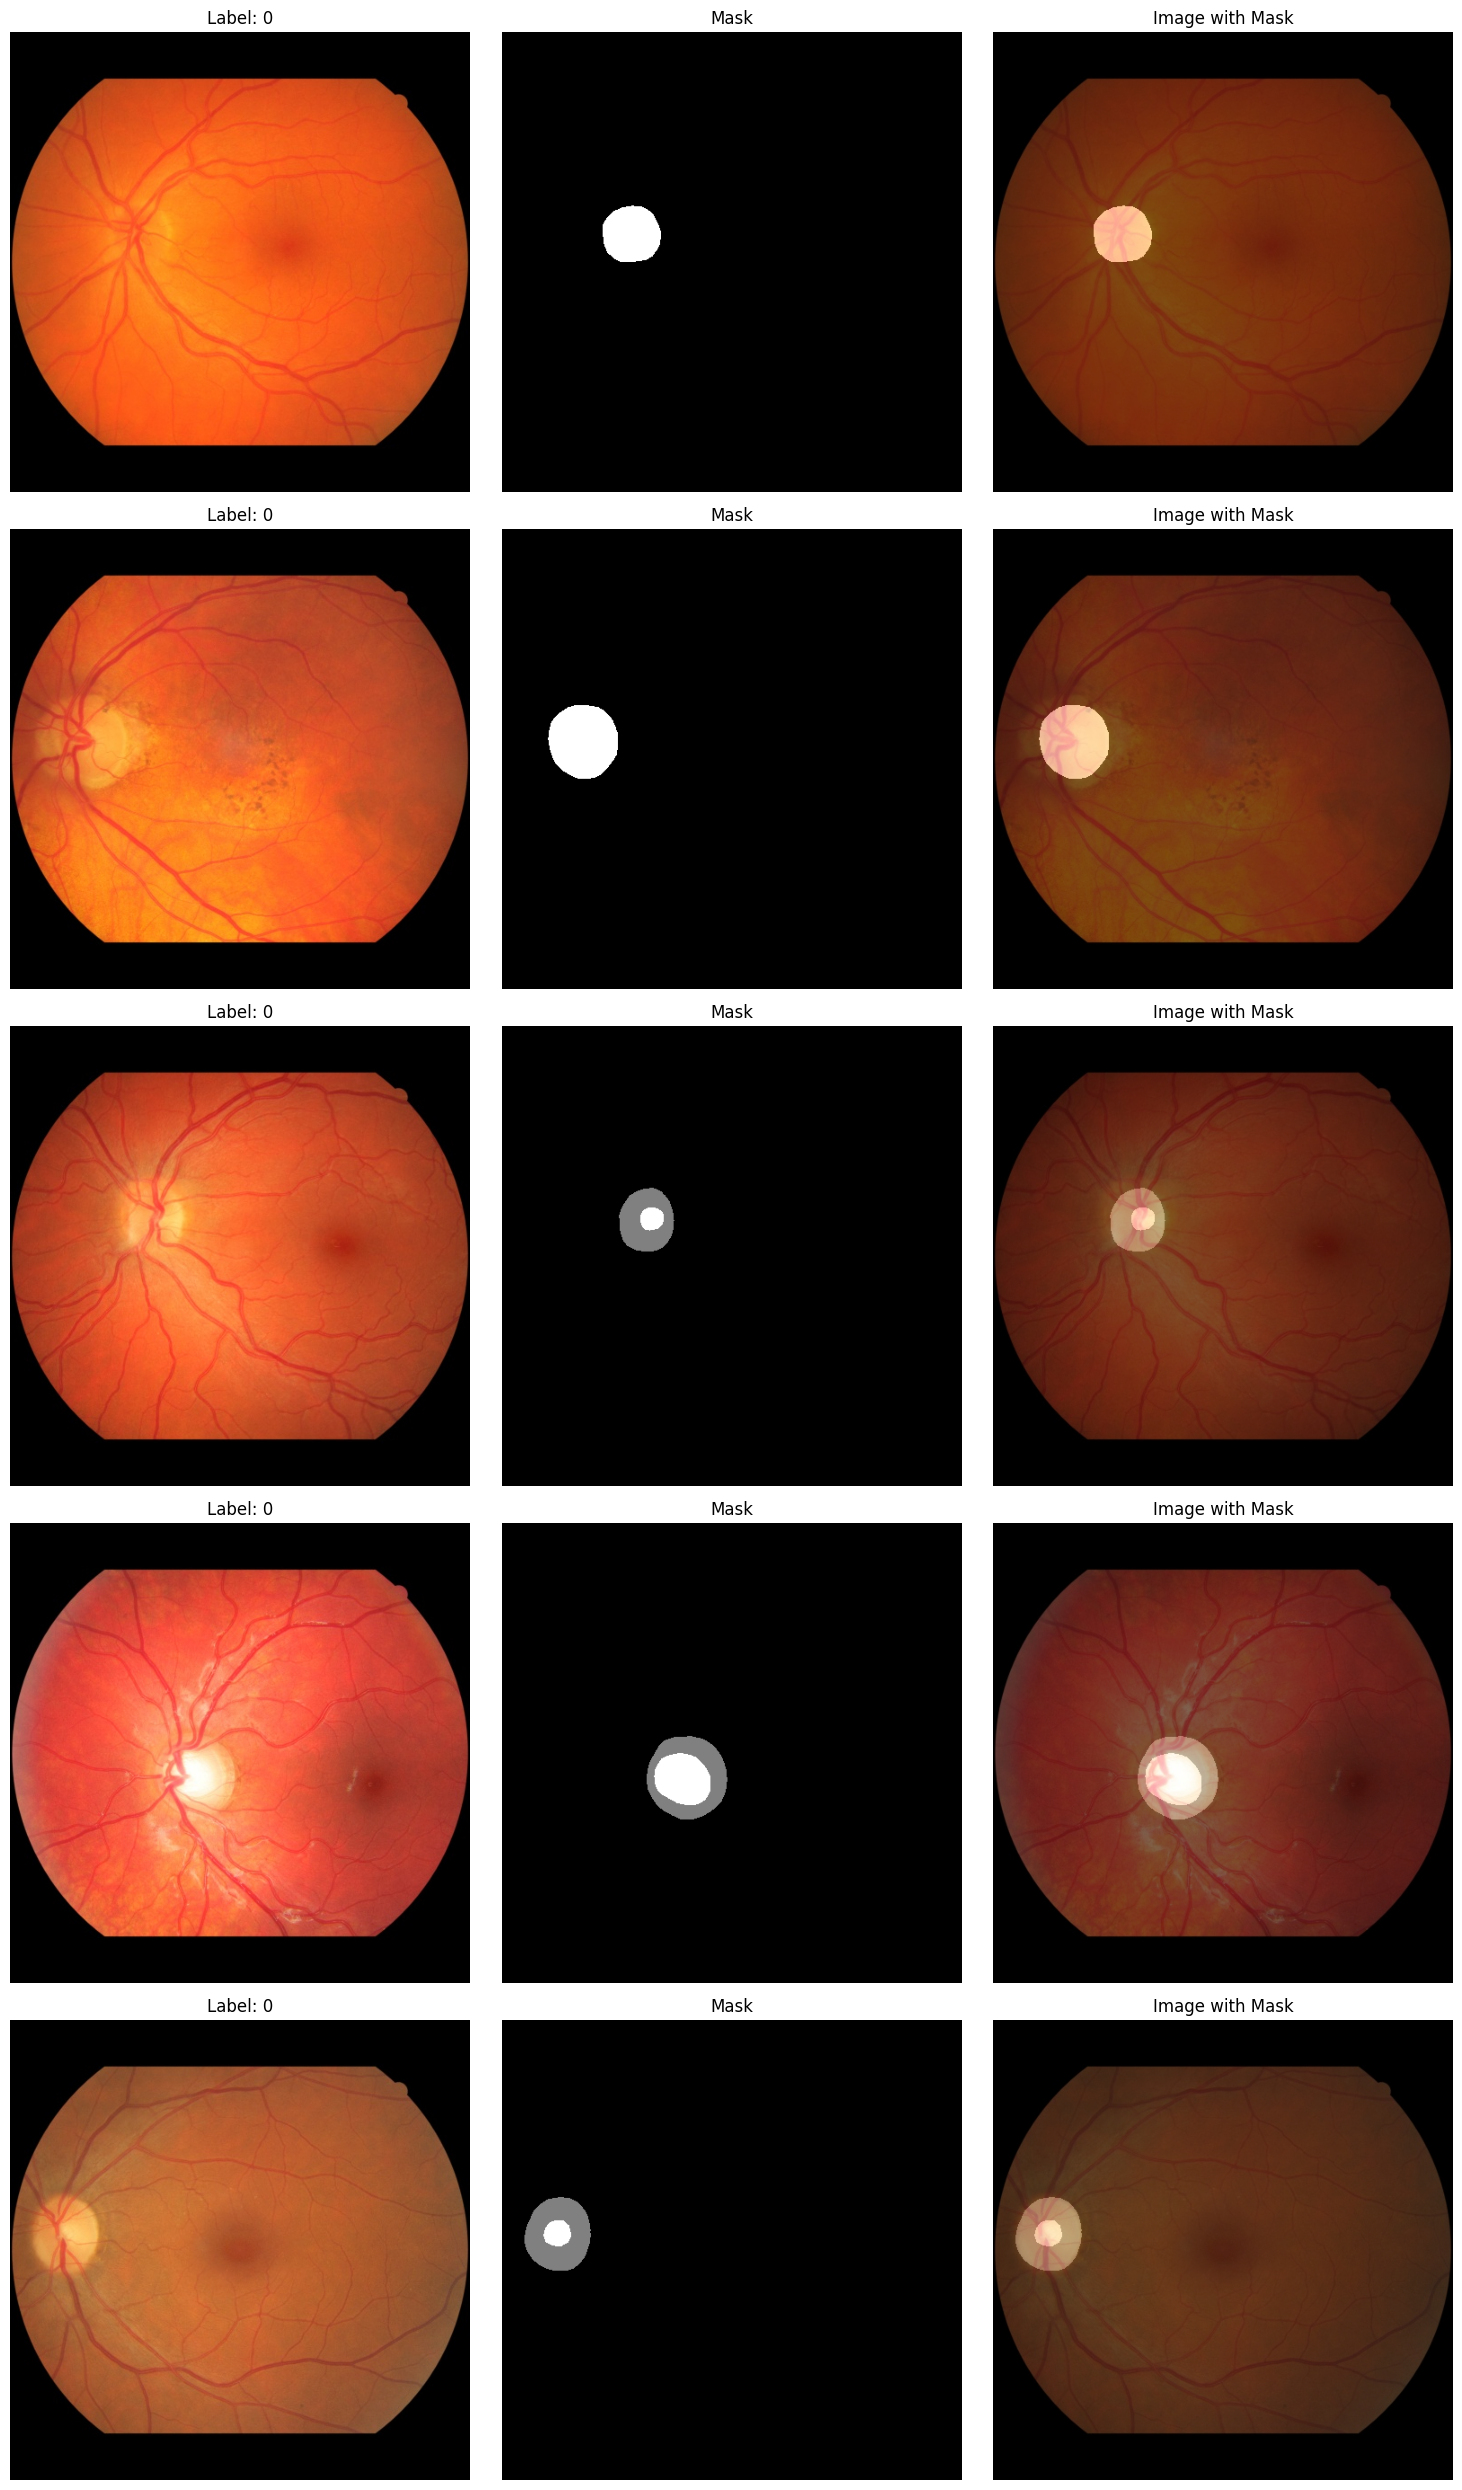

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Number of images to display
n_images = 5

# Randomly select n_images from the dataset
indices = np.random.choice(len(dataset), n_images, replace=False)
selected_images = [dataset[i] for i in indices]

# Plot the images with their masks and labels
fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
if n_images == 1:
    axes = np.expand_dims(axes, 0)
for i, (img_with_mask, label) in enumerate(selected_images):
    # Extract the image and mask from the combined tensor
    img = img_with_mask[:3, :, :]
    mask = img_with_mask[3, :, :]

    # Convert the image and mask to NumPy arrays for plotting
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # Normalize image values to [0, 1] if they're not already
    if img_np.max() > 1:
        img_np = img_np / 255.0

    # Display image
    ax = axes[i, 0]
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f'Label: {label.item()}')

    # Display mask
    ax = axes[i, 1]
    ax.imshow(mask_np, cmap='gray')
    ax.axis('off')
    ax.set_title('Mask')

    # Display image with mask overlaid
    ax = axes[i, 2]
    ax.imshow(img_np)
    ax.imshow(mask_np, cmap='gray', alpha=0.5)
    ax.axis('off')
    ax.set_title('Image with Mask')

plt.tight_layout()
plt.show()


# split dataset

In [10]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [11]:
train_loader = DataLoader(train_dataset,num_workers=2, batch_size=batch_size, shuffle=True)

In [12]:
val_loader = DataLoader(val_dataset,num_workers=2, batch_size=batch_size, shuffle=False)

# Initialize model

In [13]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b6', num_classes=2, pretrained=True):
        super(CustomEfficientNet, self).__init__()

        # Define 3 convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(5, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU(inplace=True)

        # Initialize EfficientNet model
        self.model = timm.create_model(model_name,num_classes=num_classes,pretrained=pretrained, )

        # Modify the first convolutional layer of EfficientNet to accept 64 input channels
        self.model.conv_stem = nn.Conv2d(64, self.model.conv_stem.out_channels,
                                         kernel_size=self.model.conv_stem.kernel_size,
                                         stride=self.model.conv_stem.stride,
                                         padding=self.model.conv_stem.padding,
                                         bias=False)

        # Modify the batch normalization layer of EfficientNet
        self.model.bn1 = nn.BatchNorm2d(self.model.conv_stem.out_channels)

    def forward(self, x):
        # Apply 3 convolutional layers for feature extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Forward pass through EfficientNet model
        x = self.model(x)
        return x


In [14]:

class CustomInceptionResNet(nn.Module):
    def __init__(self, model_name='inception_resnet_v2', num_classes=2, pretrained=True):
        super(CustomInceptionResNet, self).__init__()

        # Define 3 convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(5, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)

        # Initialize InceptionResNet model
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

        # Modify the first convolutional layer to accept 64 channels instead of 3
        self.model.conv2d_1a.conv = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

    def forward(self, x):
        # Apply 3 convolutional layers for feature extraction
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)

        # Forward pass through InceptionResNet model
        x = self.model(x)
        return x


In [15]:
# # Initialize the model

# model = CustomEfficientNet().to(device)

In [16]:

# Initialize the model
# model =CustomInceptionResNet().to(device)

# Hyper params and other stuff

# Training

In [17]:

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

In [18]:

model = CustomEfficientNet( model_name='efficientnet_b6', num_classes=2, pretrained=False).to(device)
# Initialize optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Loss function
criterion = torch.nn.CrossEntropyLoss()


# Training loop
num_epochs = 35



best_val_loss = float('inf')
patience = 8
early_stopping_counter = 0

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []


for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    total_train_samples = 0
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted_train = torch.max(outputs, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = (total_train_loss / len(train_loader))
    train_loss_list.append(avg_train_loss)

    train_accuracy = (total_correct_train / total_train_samples) *100
    train_accuracy_list.append(train_accuracy)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_correct_val = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_correct_val += (predicted_val == labels).sum().item()
            total_val_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)

    val_accuracy = (total_correct_val / total_val_samples) *100
    val_accuracy_list.append(val_accuracy)

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Print loss and accuracy for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy :.2f}%, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy :.2f}%")

    # Save model and lists if validation loss has improved
    if epoch > 5 and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "drive/MyDrive/best_model.pth")
        print("Model saved")
        # Also save the lists
        with open('drive/MyDrive/training_metrics.pkl', 'wb') as f:
            pickle.dump({
                'train_loss_list': train_loss_list,
                'val_loss_list': val_loss_list,
                'train_accuracy_list': train_accuracy_list,
                'val_accuracy_list': val_accuracy_list
            }, f)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# Load the best model
model.load_state_dict(torch.load("drive/MyDrive/best_model.pth"))
print("Best model loaded")

# Load the lists
with open('drive/MyDrive/training_metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
    train_loss_list = metrics['train_loss_list']
    val_loss_list = metrics['val_loss_list']
    train_accuracy_list = metrics['train_accuracy_list']
    val_accuracy_list = metrics['val_accuracy_list']

print("Metrics loaded")


Epoch 1/35, Train Loss: 6.279140863932815, Train Accuracy: 58.46%, Val Loss: 0.5840092255518987, Val Accuracy: 72.55%
Epoch 2/35, Train Loss: 0.8749551299740287, Train Accuracy: 65.56%, Val Loss: 23.595190268296463, Val Accuracy: 71.57%
Epoch 3/35, Train Loss: 1.0688072431321238, Train Accuracy: 64.09%, Val Loss: 6.2011762123841505, Val Accuracy: 72.55%
Epoch 4/35, Train Loss: 1.6400029846266204, Train Accuracy: 59.68%, Val Loss: 10.873574087252983, Val Accuracy: 72.55%
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/35, Train Loss: 0.8100726101912704, Train Accuracy: 68.63%, Val Loss: 3.4027935289419613, Val Accuracy: 71.57%
Epoch 6/35, Train Loss: 0.7085154687657076, Train Accuracy: 70.10%, Val Loss: 0.9790342312592727, Val Accuracy: 71.57%
Epoch 7/35, Train Loss: 0.5780050415618747, Train Accuracy: 69.24%, Val Loss: 0.862680964745008, Val Accuracy: 72.55%
Model saved
Epoch 8/35, Train Loss: 0.5603231396160874, Train Accuracy: 71.45%, Val Loss: 1.690580633970407

# Evaluation

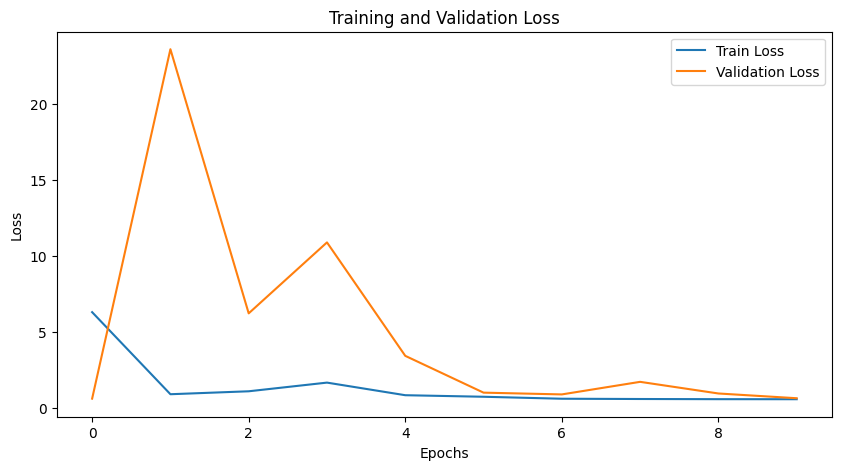

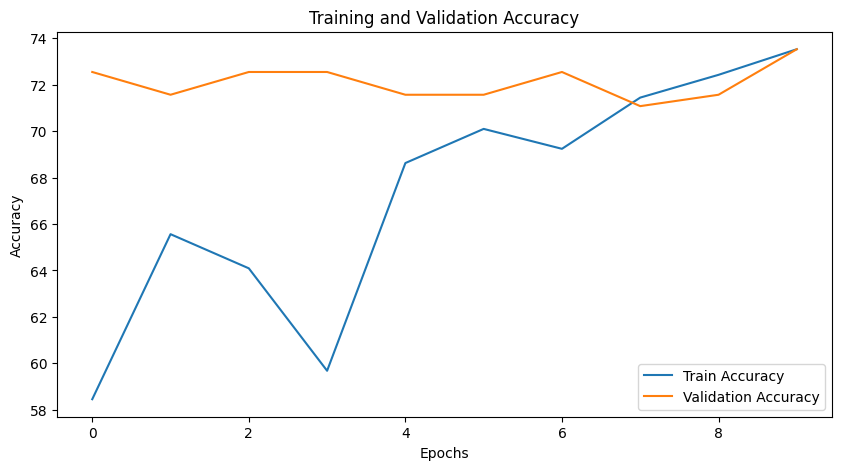

In [19]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84       148
           1       0.58      0.12      0.21        56

    accuracy                           0.74       204
   macro avg       0.66      0.55      0.52       204
weighted avg       0.70      0.74      0.67       204



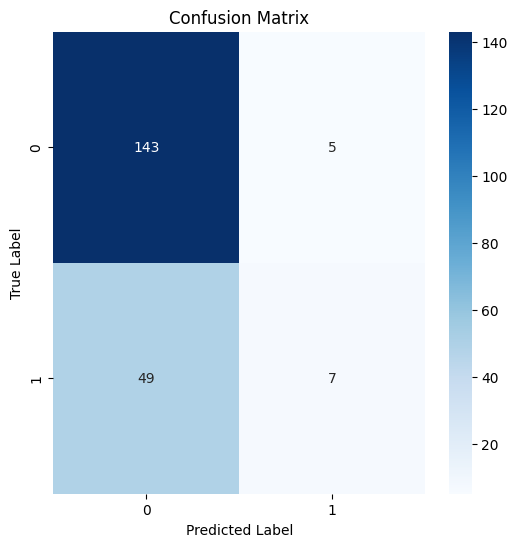

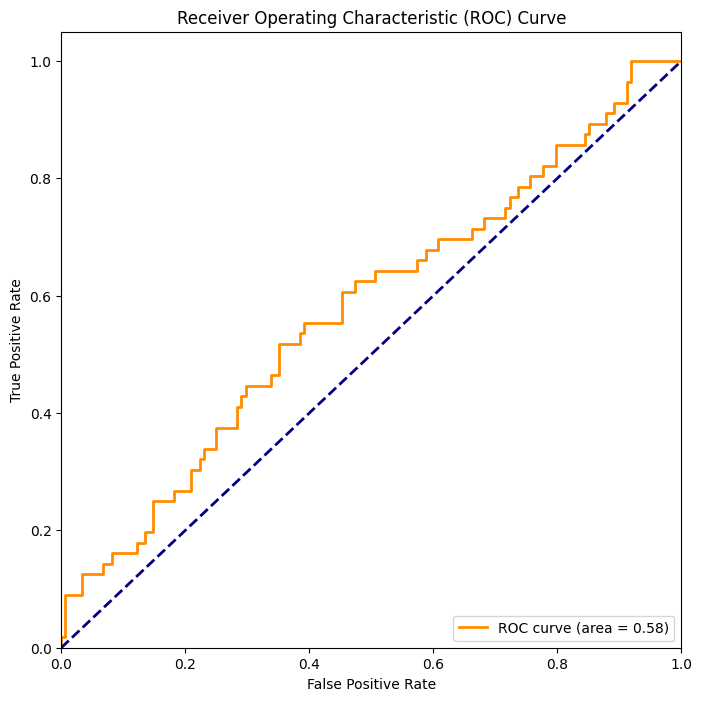

In [20]:


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store true labels, predicted labels, and predicted probabilities
true_labels = []
predicted_labels = []
predicted_probs = []

# Validation loop
model.eval()
with torch.no_grad():
    for batch in val_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Store true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())

        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

        # Store predicted probabilities for the positive class
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
        predicted_probs.extend(probs.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print('Classification Report:\n', report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Evaluation - visualised

In [21]:
! pip install grad-cam


In [22]:

import random

# Load 10 random images from the validation set
images = []
labels = []
for _ in range(10):
    idx = random.randint(0, len(val_loader.dataset) - 1)
    img, label = val_loader.dataset[idx]
    images.append(img)
    labels.append(label)


In [23]:
# images

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


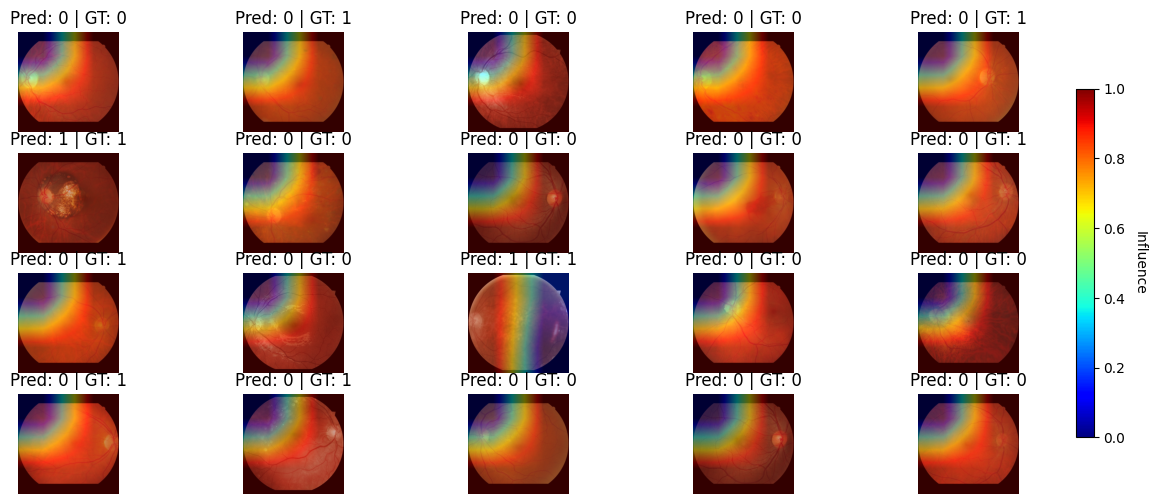

In [24]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random

# Load 10 random images from the validation set
images = []
labels = []
num_images=20
for _ in range(20):
    idx = random.randint(0, len(val_loader.dataset) - 1)
    img, label = val_loader.dataset[idx]
    images.append(img)
    labels.append(label)

# Convert the list of images to a torch tensor
images = torch.stack(images)
labels = torch.tensor(labels)

# Load the model and set it to evaluation mode
model.eval()

# Hook to extract the feature maps and gradients
feature_maps = []
gradients = []
def forward_hook(module, input, output):
    feature_maps.append(output)
def backward_hook(module, input, output):
    gradients.append(output[0])

# Register the hooks
model.model.blocks[-1].register_forward_hook(forward_hook)
model.model.blocks[-1].register_backward_hook(backward_hook)

# Forward pass and compute Grad-CAM
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Compute gradients
outputs[:, predicted].backward(torch.ones_like(outputs[:, predicted]))

# Compute weights
weights = torch.mean(gradients[0], dim=(2, 3))

# Compute Grad-CAM heatmap
heatmaps = []
for i in range(images.size(0)):
    heatmap = torch.sum(weights[i].view(-1, 1, 1) * feature_maps[0][i], dim=0)
    heatmap = F.relu(heatmap)
    heatmap = heatmap / torch.max(heatmap)
    heatmaps.append(heatmap.cpu().detach().numpy())

# Convert images to NumPy array
images_np = images.cpu().numpy()

# Overlay heatmap on original images and display them
fig, axes = plt.subplots(4, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(num_images):
    ax = axes[i]
    img = images_np[i][:3, :, :].transpose((1, 2, 0))  # Extract first 3 channels and convert from CHW to HWC format
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    img = np.uint8(255 * img)  # Convert to uint8
    heatmap = heatmaps[i]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    ax.imshow(superimposed_img)
    ax.set_title(f'Pred: {predicted[i].item()} | GT: {labels[i].item()}')
    ax.axis('off')



# Add color bar
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.05)
cbar.set_label('Influence', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()